In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('ContinuousTimeSeriesBiogasDataset.csv')

# Parse the Time column and set it as the index
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Select features and target (predicting CH4 for this example)
features = ['CO2', 'Temperature', 'pH', 'Pressure']

target = 'CH4'

# Scale the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_features = scaler_features.fit_transform(data[features])
scaled_target = scaler_target.fit_transform(data[[target]])

# Create sequences for LSTM
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24  # Using past 24 time steps (e.g., hours)
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Split into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)  # 75% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6667, random_state=42, shuffle=False)  # 15% testing, 5% validation

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred_rescaled = scaler_target.inverse_transform(y_pred)
y_test_rescaled = scaler_target.inverse_transform(y_test)



FileNotFoundError: [Errno 2] No such file or directory: 'ContinuousTimeSeriesBiogasDataset.csv'

Mean Absolute Error (MAE): 2.6550489700927975
Root Mean Square Error (RMSE): 3.38882144475499
Accuracy: 94.46%


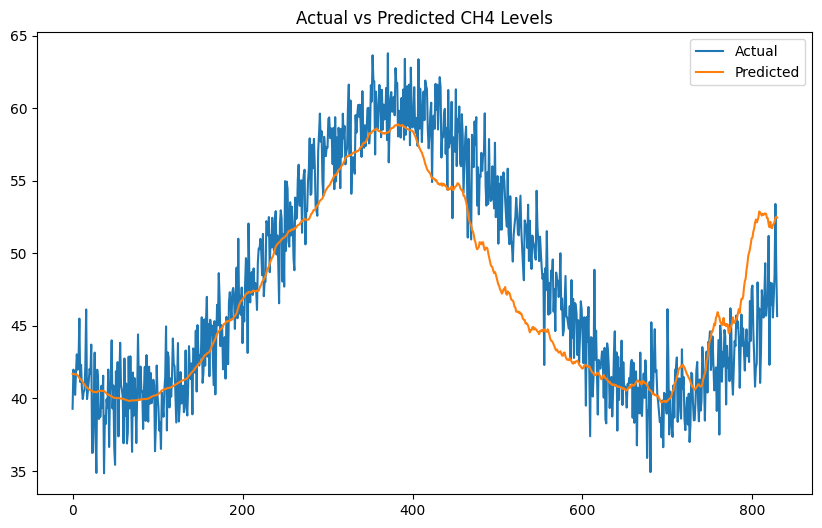

In [ ]:
# Evaluate the model
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Calculate accuracy
accuracy = 100 - (mae / np.mean(y_test_rescaled) * 100)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted CH4 Levels')
plt.show()